# Práctica - Segundo parcial

Alejandro Noel Hernández Gutiérrez

Ingeniería de características

Docente Carlos Augusto Arellano Muro

Instituto tecnológico y de estudios superiores de occidente

En el siguiete archivo practica2.xlsx, se muestran evaluaciones de una biblioteca en España, el objetivo es encontrar una relación entre las evaluaciones específicas (Estado del material, Organización, Trato, etc.) y la Valoración Global.
1. Elimine las observaciones que no tengan un dato en VALORACION GLOBAL
2. Codifique la variable '<5 CAUSA'
3. Evalúe las variables con una transformación de potencia para compensar el sesgo lo mejor posible
4. Impute los valores faltantes por media, mediana, valores aleatorios o moda, según convenga
5. Encuentre un modelo que relacione las evaluaciones específicas junto con la variable codificada de '<5 CAUSA' con el target VALORACION GLOBAL (El modelo recomendado es Árboles de decisión sklearn.tree.DecisionTreeRegresor)

In [1]:
# Librerías
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from nltk.corpus import stopwords
from janitor import clean_names
import matplotlib.pyplot as plt

In [2]:
# Lectura de archivo
excel = pd.read_excel("practica2.xlsx")
excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ADECUACIÓN COLECCIÓN  985 non-null    object
 1   ESTADO MATERIAL       1019 non-null   object
 2   ORGANIZACIÓN          1010 non-null   object
 3   ORDENACIÓN            1011 non-null   object
 4   TRATO                 1079 non-null   object
 5   INFORMACIÓN.1         937 non-null    object
 6   HORARIO               1030 non-null   object
 7   WIFI.1                578 non-null    object
 8   ESTADO                1073 non-null   object
 9   LIMPIEZA              1084 non-null   object
 10  <5 CAUSA              203 non-null    object
 11  VALORACION GLOBAL     1097 non-null   object
dtypes: object(12)
memory usage: 104.4+ KB


In [3]:
# Elimine las observaciones que no tengan un dato en VALORACION GLOBAL
excel = excel.dropna(subset=['VALORACION GLOBAL'])
excel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097 entries, 0 to 1111
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ADECUACIÓN COLECCIÓN  979 non-null    object
 1   ESTADO MATERIAL       1013 non-null   object
 2   ORGANIZACIÓN          1004 non-null   object
 3   ORDENACIÓN            1005 non-null   object
 4   TRATO                 1072 non-null   object
 5   INFORMACIÓN.1         933 non-null    object
 6   HORARIO               1025 non-null   object
 7   WIFI.1                575 non-null    object
 8   ESTADO                1069 non-null   object
 9   LIMPIEZA              1079 non-null   object
 10  <5 CAUSA              203 non-null    object
 11  VALORACION GLOBAL     1097 non-null   object
dtypes: object(12)
memory usage: 111.4+ KB


In [4]:
# Observamos que ya no existen valores null para la columna valoración global
excel['VALORACION GLOBAL'].isnull().values.any()

False

In [5]:
# Clean Names hace nombres más sencillos sin espacios o caracteres especiales
df  = clean_names(excel)
df.head()

,adecuacion_coleccion,estado_material,organizacion,ordenacion,trato,informacion_1,horario,wifi_1,estado,limpieza,<5_causa,valoracion_global
0,8,8,8,8,9,8,8,7,8,8,NaN,9
1,NaN,10,9,10,10,NaN,8,NaN,9,9,NaN,9
2,8,10,7,7,10,7,8,8,8,8,NaN,7
3,9,8,8,9,10,10,5,5,7,10,NaN,9
4,8,9,8,9,9,9,NaN,NaN,9,9,NaN,9


In [6]:
# Eliminar palabras que causan ruido
df = df.replace(['No uso','no',' ','1o'],np.NaN)
# Resetear Index
df = df.reset_index(drop=True)

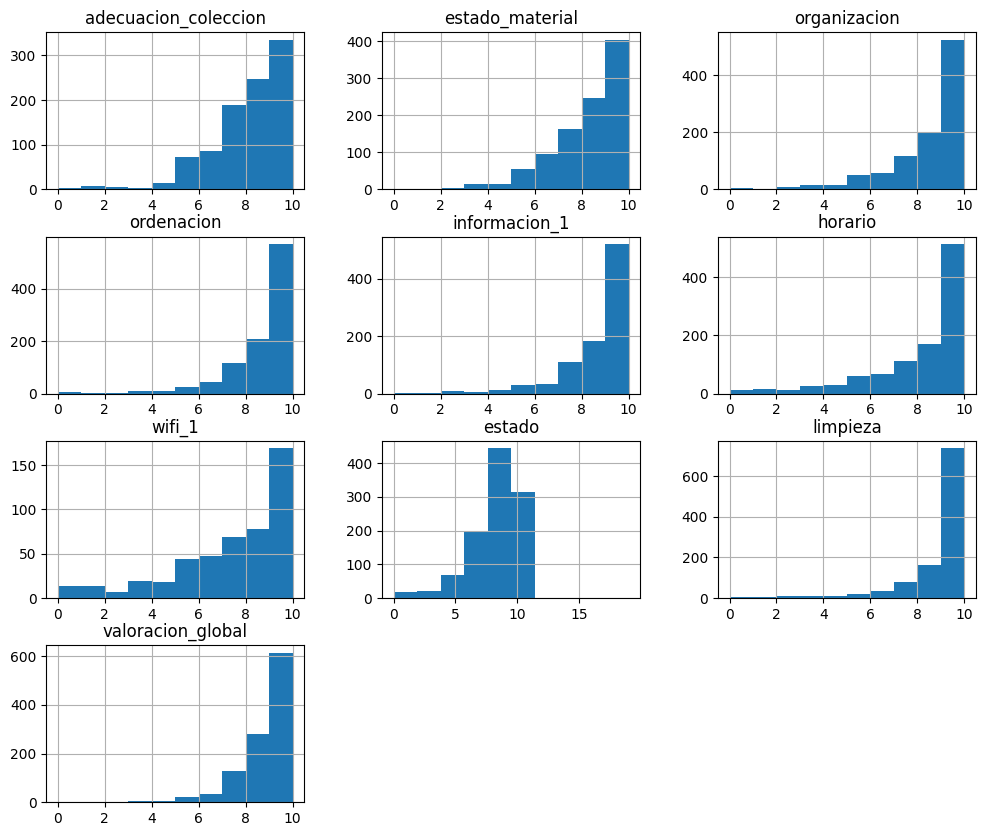

In [7]:
plot = df.hist(figsize=(12,10))

In [8]:
# Asignar index en columna fija
df['id']=df.reset_index().index
df.head()

,adecuacion_coleccion,estado_material,organizacion,ordenacion,trato,informacion_1,horario,wifi_1,estado,limpieza,<5_causa,valoracion_global,id
0,8.0,8.0,8.0,8.0,9,8.0,8.0,7.0,8.0,8.0,NaN,9.0,0
1,NaN,10.0,9.0,10.0,10,NaN,8.0,NaN,9.0,9.0,NaN,9.0,1
2,8.0,10.0,7.0,7.0,10,7.0,8.0,8.0,8.0,8.0,NaN,7.0,2
3,9.0,8.0,8.0,9.0,10,10.0,5.0,5.0,7.0,10.0,NaN,9.0,3
4,8.0,9.0,8.0,9.0,9,9.0,NaN,NaN,9.0,9.0,NaN,9.0,4


In [9]:
# Obtener columnas numéricas con excepción de la salida
df_numeric = df.drop(['<5_causa'],axis = 1).astype('float')
df_numeric.columns

Index(['adecuacion_coleccion', 'estado_material', 'organizacion', 'ordenacion',
       'trato', 'informacion_1', 'horario', 'wifi_1', 'estado', 'limpieza',
       'valoracion_global', 'id'],
      dtype='object')

In [10]:
# Imputación de datos con la mediana
df_numeric[df_numeric.columns] = SimpleImputer(strategy='median').fit_transform(df_numeric[df_numeric.columns])
# Valoración del dataframe para encontrar casos extraños
df_numeric.describe()

,adecuacion_coleccion,estado_material,organizacion,ordenacion,trato,informacion_1,horario,wifi_1,estado,limpieza,valoracion_global,id
count,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,7.744758,7.891522,8.231541,8.468551,9.185506,8.538742,7.927985,7.601641,8.139471,8.712853,8.473108,548.000000
std,1.660658,1.661086,1.846576,1.652571,1.438997,1.591665,2.264312,1.764129,2.031607,1.729560,1.349999,316.820927
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,7.000000,8.000000,9.000000,8.000000,7.000000,8.000000,7.000000,8.000000,8.000000,274.000000
50%,8.000000,8.000000,9.000000,9.000000,10.000000,9.000000,9.000000,8.000000,9.000000,9.000000,9.000000,548.000000
75%,9.000000,9.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.000000,10.000000,10.000000,9.000000,822.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,19.000000,10.000000,10.000000,1096.000000


In [11]:
# Transformación de datos
df_inputs = df_numeric.columns.difference(['id','valoracion_global'])

# yeo-johnson
pw = PowerTransformer(method='yeo-johnson')
# FIT 
df_numeric[df_inputs] = pw.fit_transform(df_numeric[df_inputs])
df_numeric

,adecuacion_coleccion,estado_material,organizacion,ordenacion,trato,informacion_1,horario,wifi_1,estado,limpieza,valoracion_global,id
0,0.037279,-0.072756,-0.397804,-0.586679,-0.640905,-0.666652,-0.201810,-0.654844,-0.217617,-0.836139,9.0,0.0
1,0.037279,1.517583,0.331286,1.224834,0.756325,0.145962,-0.201810,0.090402,0.376508,-0.064324,9.0,1.0
2,0.037279,1.517583,-0.968633,-1.184006,0.756325,-1.257874,-0.201810,0.090402,-0.217617,-0.836139,7.0,2.0
3,0.793687,-0.072756,-0.397804,0.204909,0.756325,1.227960,-1.469851,-1.690133,-0.743607,0.996407,9.0,3.0
4,0.037279,0.664564,-0.397804,0.204909,-0.640905,0.145962,0.418993,0.090402,0.376508,-0.064324,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1092,1.659053,0.664564,1.240011,1.224834,-1.419108,1.227960,-0.718332,0.090402,1.039456,0.996407,8.0,1092.0
1093,0.037279,-0.072756,0.331286,0.204909,0.756325,0.145962,-0.718332,0.090402,0.376508,-0.064324,7.0,1093.0
1094,0.037279,-0.072756,0.331286,0.204909,0.756325,0.145962,0.418993,0.090402,0.376508,-0.064324,8.0,1094.0
1095,-1.164536,-1.646728,-0.397804,-0.586679,-2.021212,-1.257874,-1.138317,-2.239119,0.376508,-2.229662,5.0,1095.0


In [12]:
df_inputs

Index(['adecuacion_coleccion', 'estado', 'estado_material', 'horario',
       'informacion_1', 'limpieza', 'ordenacion', 'organizacion', 'trato',
       'wifi_1'],
      dtype='object')

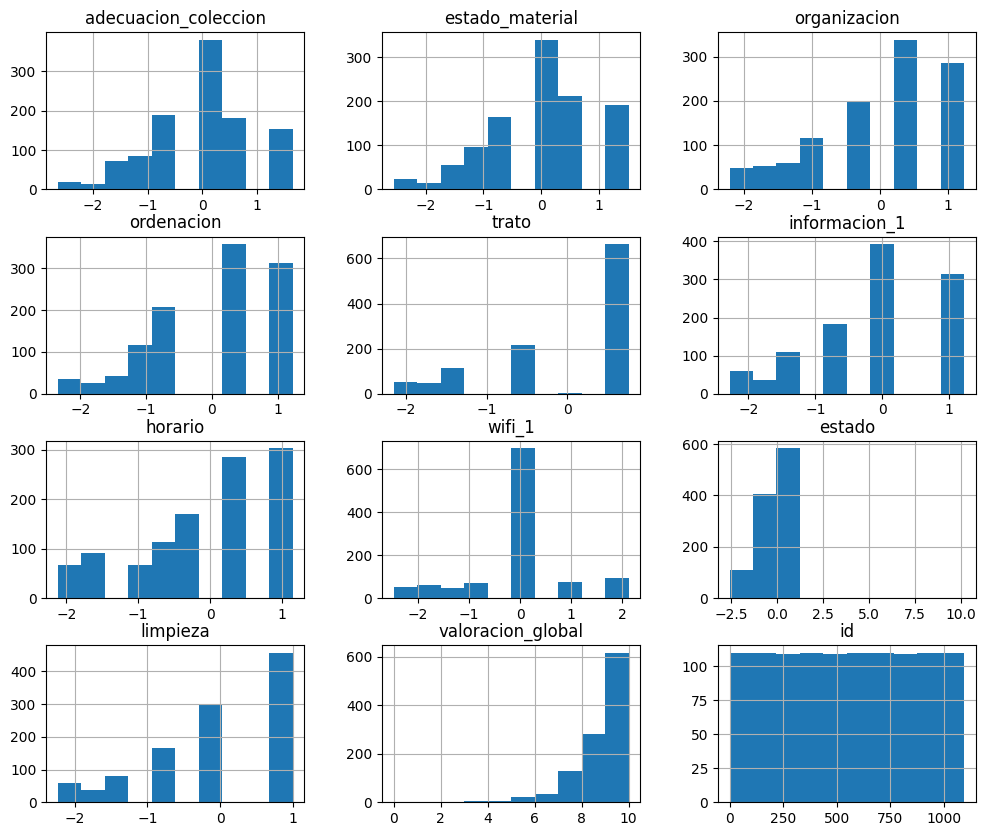

In [13]:
# Plot con la transformación de datos
plot = df_numeric.hist(figsize=(12,10))

# Codifique la variable '<5 CAUSA'  

In [14]:
# Desde la librería stopwords, traemos las stop words tipicas en Español.
stop_words_array = stopwords.words("spanish")
stop_words_array[0:15] # Visualizar primeros 15

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con']

In [15]:
# Se defione el vectorizador
# Partimos de que cada ROW del dataset es un documento
vectorizer = TfidfVectorizer(
    lowercase=True, # Convert all characters to lowercase before tokenizing.
    min_df= 2, # Umbral mínimo de frecuencia. Aparición 2 veces en el documento (row)
    max_df=.7, # Umbral máximo de frecuencia. El término debe aparecer en menos del 80% de los rows para considerarse
    stop_words=stop_words_array,
    ngram_range=(1, 2) # Generación de unigramas y bigramas
    )
vectorizer

TfidfVectorizer(max_df=0.7, min_df=2, ngram_range=(1, 2),
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...])

In [16]:
# Sustituir nan values for option other
df['<5_causa'].isna().sum()
# 893 de 1097 valores son NA

895

In [17]:
# Rellenamos los NaN values con causa desconocida o Otra
excel['<5 CAUSA'] = excel['<5 CAUSA'].fillna('Otra')

In [18]:
# No más NA:
df['<5_causa'].isna().sum()

895

In [19]:
# En la exploración se encuentran valores extraños, posiblemente equivocación de los usuarios: [7, 9 , 10, Na, no, U], reemplazamos por 'Sin información'
df['<5_causa'].isin([7, 9 , 10,'Na' , 'no', 'U']).sum()

7

In [20]:
# [7, 9 , 10, Na, no, U], reemplazamos por 'Sin información'
df=df.mask(df['<5_causa'].isin([7, 9 , 10,'Na' , 'no', 'U']), 'Sin información')

In [21]:
# Contar para asegurar que esos valores ya son 0
df['<5_causa'].isin([7, 9 , 10,'Na' , 'no', 'U']).sum()

0

In [22]:
# Copy of not na causes
df_categorical = df[['<5_causa']].astype('string')
df_categorical['id'] = df['id']
df_categorical = df_categorical.dropna()

vectorizer.fit(df_categorical['<5_causa'])
X = vectorizer.transform(df_categorical['<5_causa'])

In [23]:
TermFrecuencyInverseDocumentFrecuency_df = pd.DataFrame(data = X.toarray(),
                     columns=vectorizer.get_feature_names_out(),
                     index=df_categorical['id'])
TermFrecuencyInverseDocumentFrecuency_df.head()

,10,19,abiertas,abrigo,abrigo puesto,abrir,abrir ventanas,accesibilidad,accesible,acceso,...,ventanas abiertas,ventilación,ventilación natural,ver,verano,volver,vuelva,web,wifi,wifi falla
id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.22964,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [24]:
# Reducción de dimensionalidad con PCA
from sklearn.decomposition import PCA

# crear una instancia de la clase PCA para reducir la dimensionalidad de las reseñas codificadas
pca = PCA(n_components=2)

# reducir la dimensionalidad de las reseñas codificadas
reviews_pca = pca.fit_transform(X.toarray())
reviews_pca[0:10] # Head

array([[ 0.1657544 , -0.00949456],
       [ 0.34889768,  0.07059626],
       [ 0.41606028,  0.04133391],
       [ 0.31184615,  0.06079171],
       [ 0.02258911, -0.03469334],
       [ 0.45857569,  0.09792461],
       [-0.11711341, -0.03790343],
       [ 0.10628724, -0.01555265],
       [-0.09197603, -0.03349546],
       [-0.11328279, -0.09032295]])

In [25]:
# Kmeans para asignar los grupos
from sklearn.cluster import KMeans

n_grupos = 5
# crear una instancia de la clase KMeans para clasificar las reseñas por K-means
kmeans = KMeans(n_clusters=n_grupos, random_state=42)

# clasificar las reseñas por K-means
kmeans.fit(reviews_pca)

# agregar los grupos como una nueva columna al dataframe original
df_categorical['grupo'] = kmeans.labels_
df_categorical.sort_values(by='grupo', ascending=False).head()

c:\Users\nhernand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,<5_causa,id,grupo
371,Nunca funciona la claecfacción ni el aire,371,4
335,El sistema no funciona,335,4
93,el sistema ebiblio ha cambiado y el actual es ...,93,4
643,La máquina de servicio de autopréstamo no func...,643,4
625,Ebiblio funciona peor que antes,625,4


In [26]:
# Union de dataframes
tree_df = df_numeric.copy()
tree_df = tree_df.merge(TermFrecuencyInverseDocumentFrecuency_df,"left",on='id')
tree_df = tree_df.drop(['id'],axis=1)
tree_df = tree_df.fillna(0)
tree_df.head(20)

,adecuacion_coleccion,estado_material,organizacion,ordenacion,trato_x,informacion_1,horario_x,wifi_1,estado,limpieza_x,...,ventanas abiertas,ventilación,ventilación natural,ver,verano,volver,vuelva,web,wifi,wifi falla
0,0.037279,-0.072756,-0.397804,-0.586679,-0.640905,-0.666652,-0.201810,-0.654844,-0.217617,-0.836139,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.037279,1.517583,0.331286,1.224834,0.756325,0.145962,-0.201810,0.090402,0.376508,-0.064324,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.037279,1.517583,-0.968633,-1.184006,0.756325,-1.257874,-0.201810,0.090402,-0.217617,-0.836139,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.793687,-0.072756,-0.397804,0.204909,0.756325,1.227960,-1.469851,-1.690133,-0.743607,0.996407,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.037279,0.664564,-0.397804,0.204909,-0.640905,0.145962,0.418993,0.090402,0.376508,-0.064324,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
5,-1.981507,-1.646728,-1.718570,-1.922215,-0.640905,-1.946011,0.418993,0.090402,-2.598698,-2.182919,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
6,-1.164536,-1.646728,-1.718570,-1.922215,0.756325,0.145962,-1.469851,0.090402,1.039456,0.996407,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
7,0.037279,-0.072756,0.331286,0.204909,-1.419108,0.145962,-0.201810,-2.479459,0.376508,0.996407,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
8,-0.614065,-1.646728,-0.968633,-1.619179,-0.640905,-1.257874,-0.718332,-1.690133,-0.743607,-1.378282,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
9,-0.614065,0.664564,1.240011,0.204909,0.756325,0.145962,0.418993,0.090402,0.376508,-0.064324,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


### Encuentre un modelo que relacione las evaluaciones específicas junto con la variable codificada de '<5 CAUSA' con el target VALORACION GLOBAL (El modelo recomendado es Árboles de decisión sklearn.tree.DecisionTreeRegresor)

In [27]:
X = tree_df.drop(['valoracion_global'],axis = True) # Todas menos el target
y = tree_df.valoracion_global # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Arbol de decisión profundidad de 15
decision_tree_model = DecisionTreeRegressor(max_depth=15)
decision_tree_model.fit(X_train,y_train)
decision_tree_model.score(X_test,y_test)

0.3555076477471244

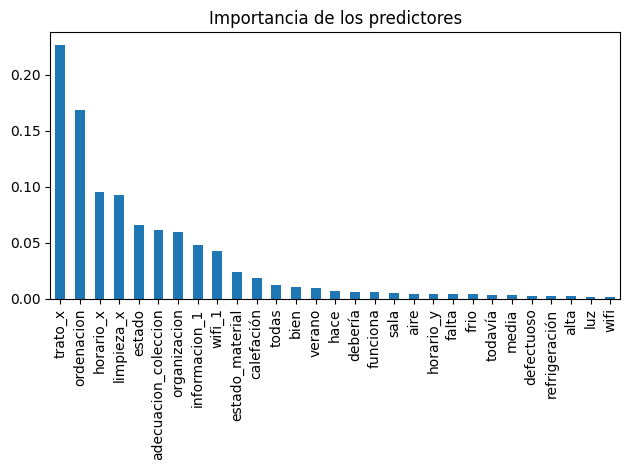

In [29]:
# Importancia de los predictores
decision_tree_importance = pd.Series(decision_tree_model.feature_importances_,index=decision_tree_model.feature_names_in_)
decision_tree_importance = decision_tree_importance.where(decision_tree_importance >0.001).dropna().sort_values(ascending=False)
fig, ax = plt.subplots()
decision_tree_importance.plot.bar()
ax.set_title("Importancia de los predictores")
fig.tight_layout()

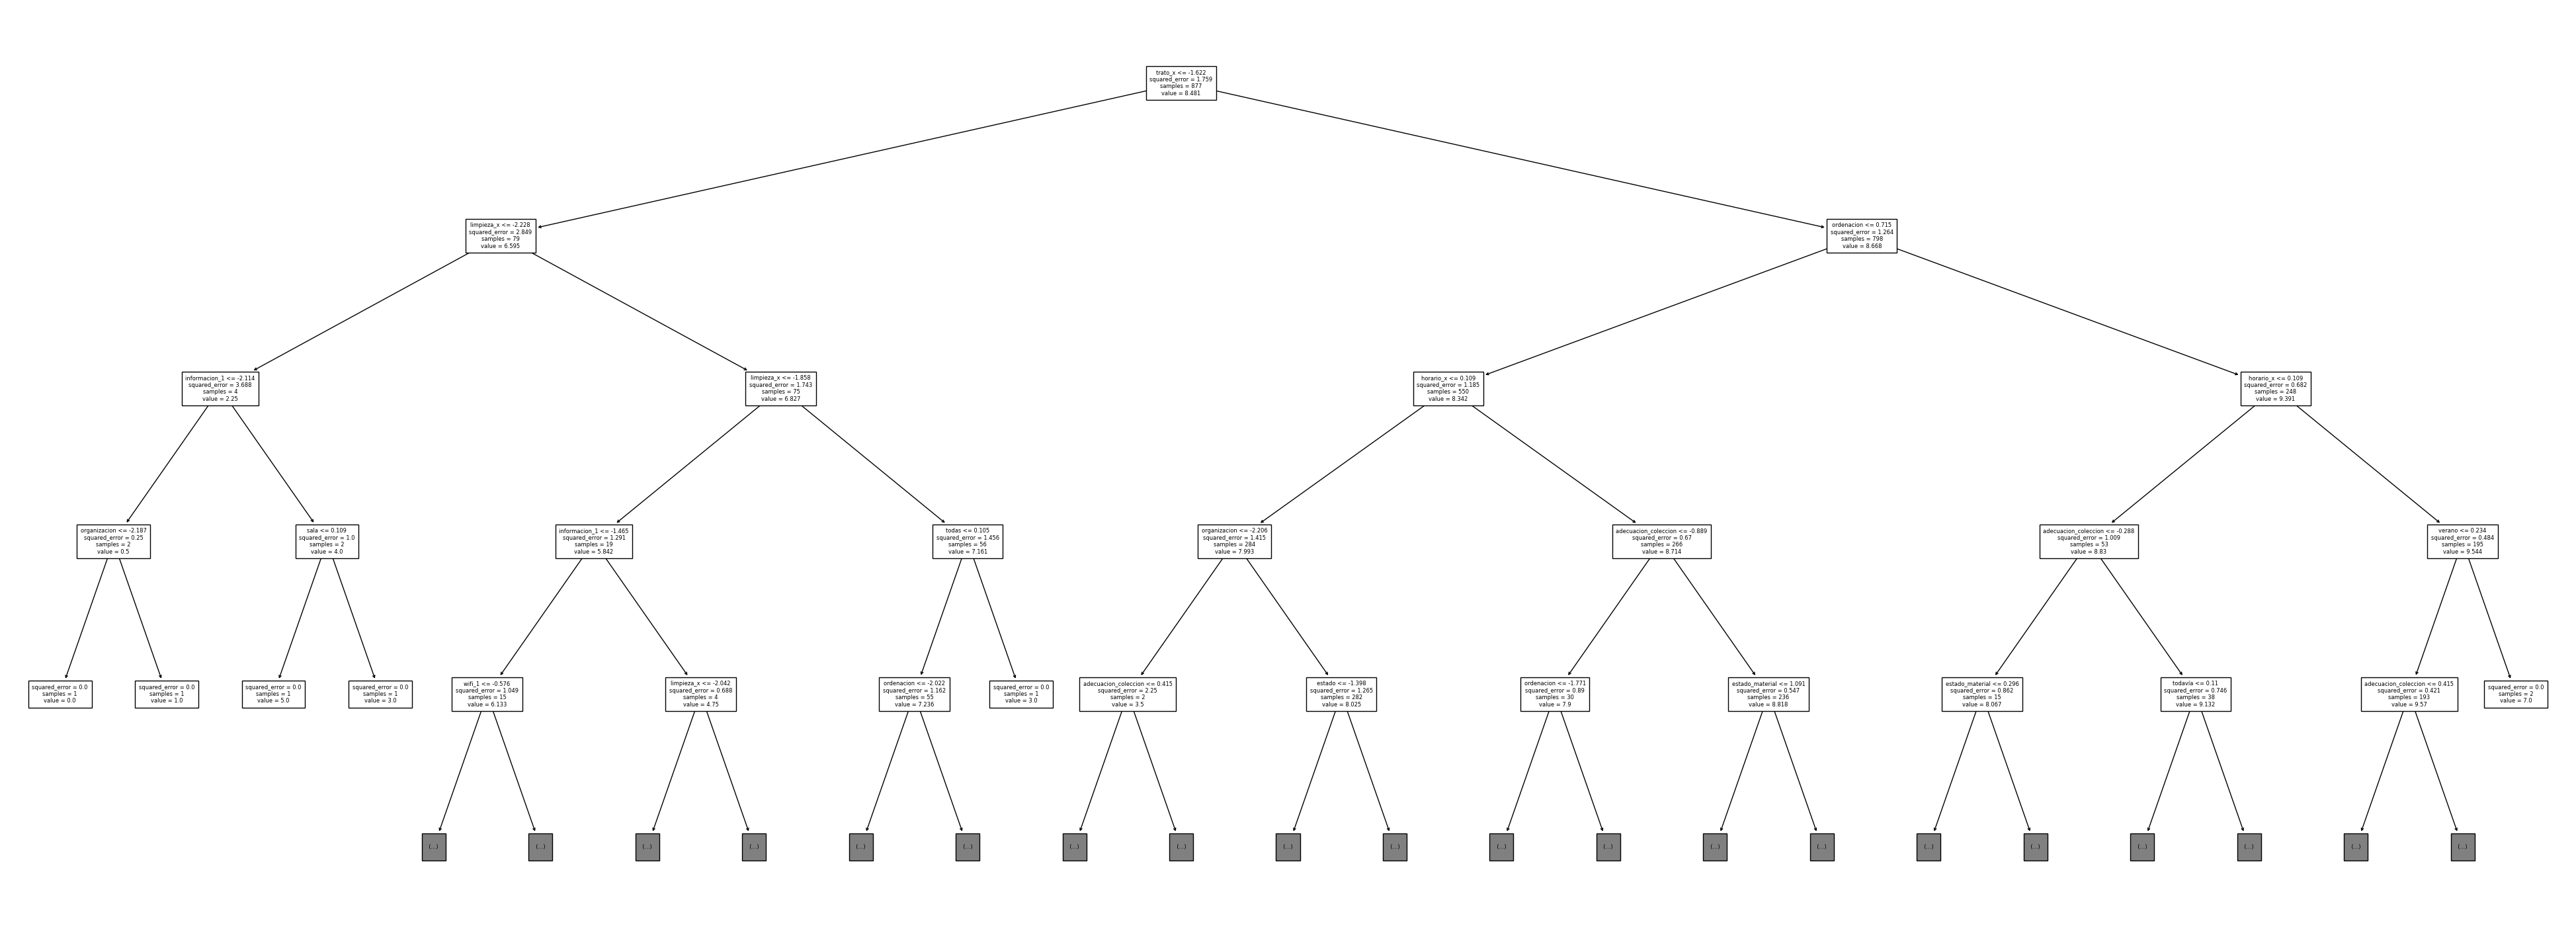

In [30]:
# Visualización del árbol
from sklearn import tree
plt.figure(figsize=(50,18))
x = tree.plot_tree(decision_tree_model, fontsize=6,feature_names=X.columns,max_depth=4)

In [31]:
decision_tree_model.fit(X_train, y_train)

score = decision_tree_model.score(X_train, y_train)
print("R-squared:", score) 

R-squared: 0.922750215857146


In [32]:
from sklearn.metrics import mean_squared_error
y_pred = decision_tree_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0)) 

MSE:  1.2300123057929662
RMSE:  1.1090591985069895


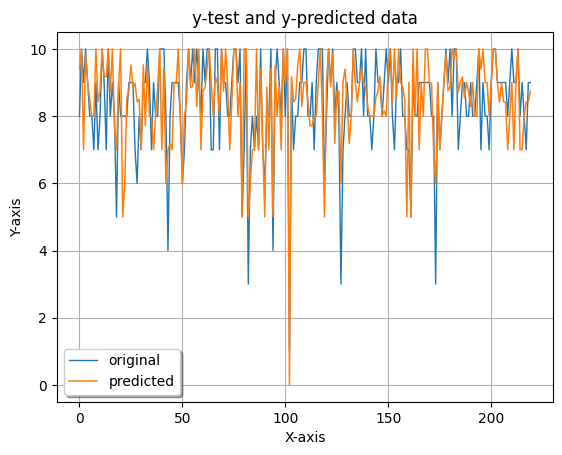

In [33]:
# Visualización
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 